In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

import statsmodels.formula.api as smf


import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

We start by loading the previously created dataframe with the answers to the questions we asked gpt. We also read the 20 questions, which are stored in `questions` below.

In [2]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


In [3]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = []

while len(line)!=0:
    questions.append(line.strip())
    line = f.readline()
    
questions = questions[1:-1]

# A) Preprocessing

In [4]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
#gpt_answers.head(3)

In [5]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [6]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)
gpt_answers.drop(columns=['response_length'], inplace=True)
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


In [7]:
for q_nb, question in enumerate(questions):
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


And let's plot how many answers to the questions were negative, positive and unknown for each question.

In [8]:
def plot(df):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(f'Question {i}')

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

#plot(gpt_answers)

In [9]:
def plot_pie_charts(df):
    fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (12,10))

    for r in range(4):
        for c in range(5):
            ax[r,c].pie(df[f'q_{r*5+c}'].value_counts(),
                        labels = df[f'q_{r*5+c}'].dropna().unique(),
                        autopct=lambda p: '{:.1f}%'.format(p),
                        startangle=90, shadow=False)
            ax[r,c].set_title(f'Question {r*5+c}')
    
    fig.suptitle('Pie charts of percentage of answers (0, 1, and 2) for each question', y=1.01, fontsize=15)
    fig.tight_layout()
            
#plot_pie_charts(gpt_answers)

In [10]:
relevant_answers = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()

print(f"There are {relevant_answers['binary_answers'].count()-relevant_answers['binary_answers'].str.contains('1').sum()} movies that do not even contain a 1")

There are 610 movies that do not even contain a 1


As seen above, there are around 600 movies that have no positive answer at all. Some examples of these movies are Spirit, Harry Potter movies... Note that these movies should not be considered romance movies in the first place ! It is thus good that GPT outputs a `00000000000000000000` when analyzing them. 

In fact, this gives us a rationale to trim even more the dataset : if a movie does not contain any of the 20 clichés, is it in fact a romance movie ? It seems that most of the all `0`'s strings are in fact from movies that are not romance centered at all. We thus choose an (arbitrary) threshold to consider a movie `Romance` : it should contain at least 3 positive answers. 

There are 4380 different answers.


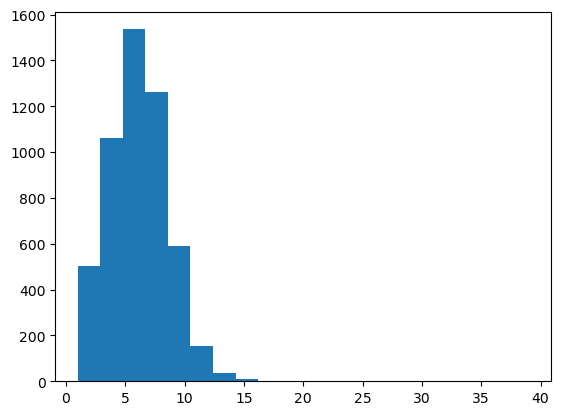

In [11]:
# First remove any string consisting of only 2s
#df = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()

# Define the questions list, ie all columns
questions_list = ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19']

# We keep only the strings with at least a 1. 
# This way we remove the all 0s strings, the all 2s strings, and the mixed strings.
data = gpt_answers[gpt_answers['binary_answers'].str.contains('1')].copy()

filenames = data['movie_id']
filenames = filenames.apply(lambda x : str(x) + '.xml.gz').values

# 4380 different binary answers
print(f"There are {len(gpt_answers['binary_answers'].unique())} different answers.")

# Remove all the entries that (somehow) have more than 20 positive answers, and then plot the histogram of #1s.
data['total'] = data[questions_list].sum(axis = 1)
#data = data[21 > data['total']]
plt.hist(data['total'], bins = 20)
plt.show()

We should expect, after keeping only movies with 3 positive answers or more, to have around 4500 movies.

In [12]:
# Keep only entries with at least 3 positive answers: this captures the "real" romance movies.
data = data[data['total'] > 0]
display(data)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19,total
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,6
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,3
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,6
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,1,0,0,1,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,4037444,00010100010001000000,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,4
5878,1191380,00001000110110100010,0,0,0,0,1,0,0,0,...,1,1,0,1,0,0,0,1,0,7
5879,54540,10000000001000010010,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,4
5880,1673588,00000001010000000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


Now that we refined our dataset, we only have $4653$ movies now. Let's plot each question's statistics !

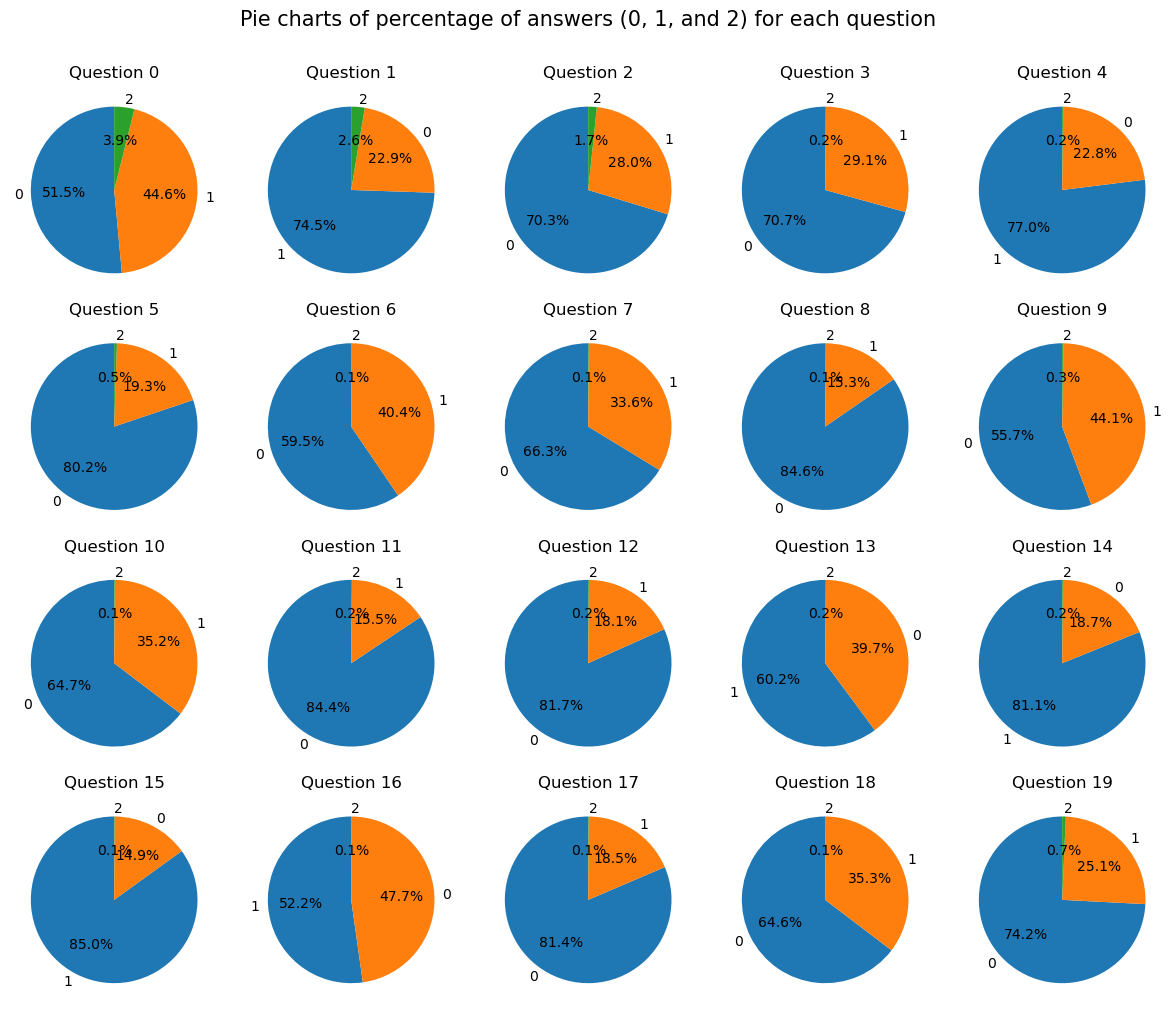

In [13]:
plot_pie_charts(data)

In [14]:
col_to_keep = ['movie_id', 'movie_release', 'binary_answers']
for i in range(len(questions)):
    col_to_keep.append(f'q_{i}')
    
# Perform a right merge : we only care about the relevant answers
gpt_year = romance_with_binary.merge(data, on=['movie_id', 'binary_answers'], how='right')[col_to_keep]
gpt_year.replace(2, np.NaN, inplace=True)

At this point, we can wonder : is there a clear trend as to how clichés evolve over time ? As an example, could we say that modern movies contain less weddings stopped at the altar ?

In [15]:
def plot_answer_by_year(df): 
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        ax[i%4, math.floor(i/4)].set_title(f'Question {i}')
        sns.lineplot(df, x='movie_release', y=f'q_{i}', ax=ax[i%4, math.floor(i/4)])

    fig.tight_layout()
    plt.show()
    
#plot_answer_by_year(gpt_year)
#plot_answer_by_year(gpt_year[gpt_year['movie_release']>1920])

In [16]:
#plot_answer_by_year(gpt_year[gpt_year['movie_release']>1920])

# B) Analysis of single questions

In [17]:
## When sophie gives tsv : just import it as df

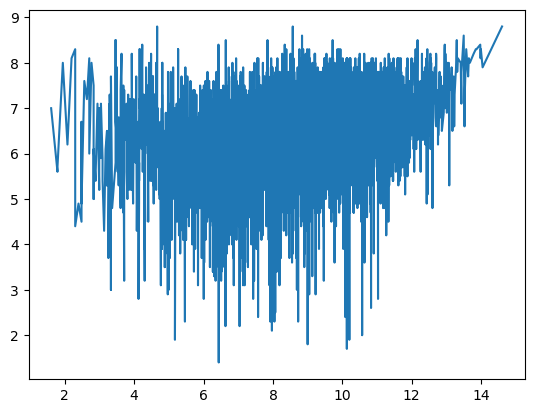

In [18]:
trimmed = data.drop(['binary_answers'], axis = 1)
trimmed = trimmed.replace(2, np.NaN)
#trimmed = trimmed.astype(pd.Int64Dtype())
df = trimmed.merge(romance_with_binary, on = 'movie_id', how = 'left')

df.drop_duplicates('movie_id', inplace=True)

# TODO : MAYBE REMOVE THIS !
#df = df[df.nb_votes > 10000]

#print(df.info())
df = df.sort_values(by='nb_votes')
plt.plot(np.log(df.nb_votes), df.rating)


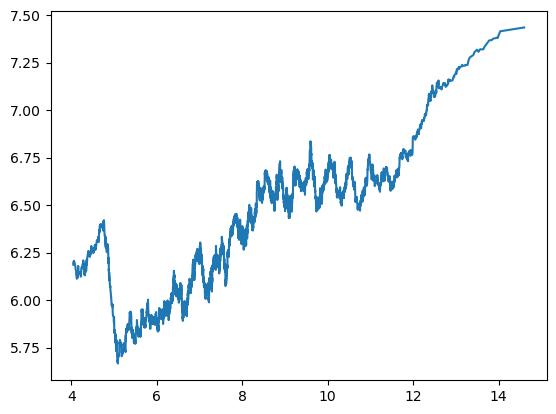

In [19]:
df_mva = df.dropna(subset = ['rating', 'nb_votes'])
df_mva['mva'] = df_mva['rating'].rolling(100).mean()
df_mva.dropna(subset = 'mva')
df_mva = df_mva.sort_values(by='nb_votes')
# moving average with a window size of 100
fig, ax = plt.subplots()

plt.plot(np.log(df_mva.nb_votes), df_mva.mva)


We want to reduce this bias! Hence, we only keep movies with more than 500 reviews.

In [20]:
df = df[(df.nb_votes > 500)].copy()

<Axes: xlabel='movie_release', ylabel='rating'>

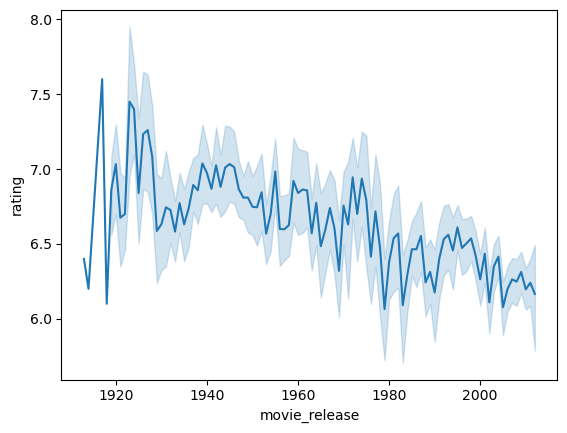

In [21]:
sns.lineplot(data=df, x='movie_release', y='rating')

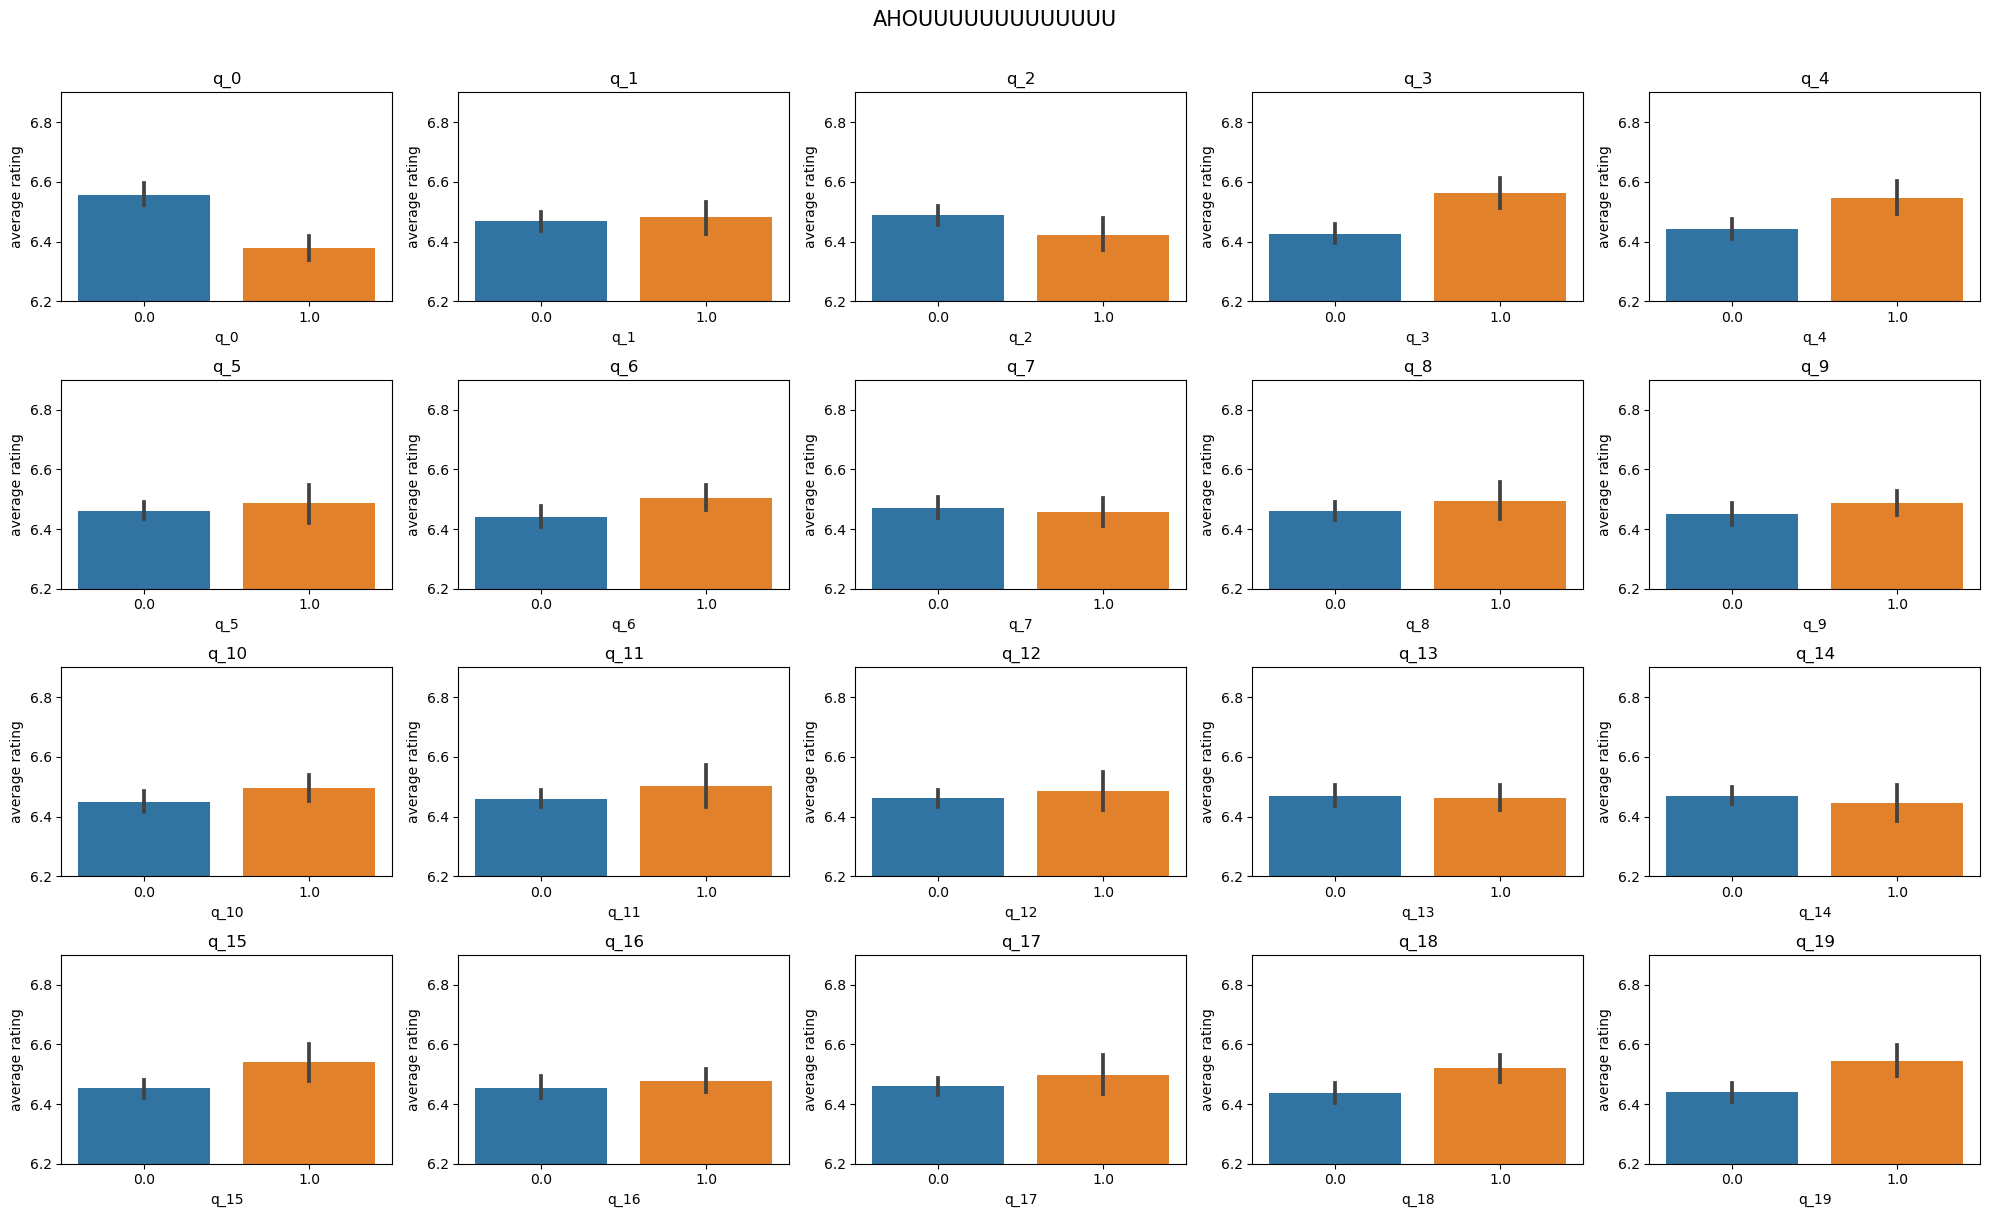

In [22]:
df["ratings_with_weight"] = [ v + w*1j for v,w in zip(df.rating, df.nb_votes)]
def weighted_mean(x, **kws):
    return np.sum(np.real(x) * np.imag(x)) / np.sum(np.imag(x))

def plot_error_bars(df, nr_rows, nr_cols, weights):
    
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
    
    for r in range(nr_rows):
        for c in range(nr_cols):
            
            index = r * 5 + c
            question = 'q_' + str(index)
            
            if weights : 
                sns.barplot(data=df, x= question, y='ratings_with_weight', ax = ax[r][c], estimator = weighted_mean, errorbar=('ci', 95))
                ax[r][c].set_ylim(6.65,7.5)
            else :
                sns.barplot(data=df, x= question, y='rating', ax = ax[r][c])
                ax[r][c].set_ylim(6.2,6.9)

            ax[r][c].set_ylabel('average rating')
            ax[r][c].set_title(question)
            #ax[r,c].set_title(question)
    
    fig.suptitle('AHOUUUUUUUUUUUUU', y=1.01, fontsize=15)
    plt.tight_layout()    
    plt.show()
    
plot_error_bars(df, 4, 5, False)
#plot_error_bars(df, 4, 5, True)

(6.1, 6.8)

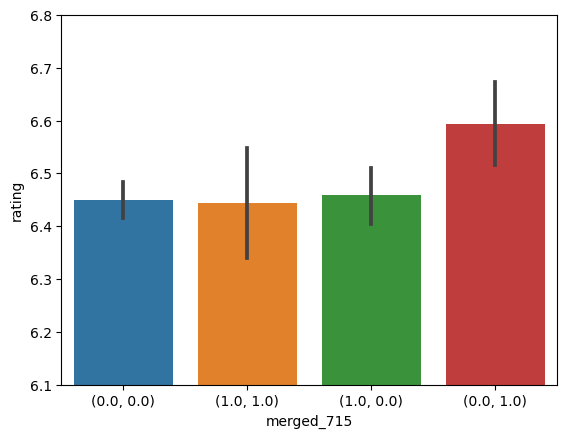

In [23]:
# This functions is to be used when analyzing pairs of questions. 
def pair_analysis(id1, id2) : 

    id1 = str(id1)
    id2 = str(id2)
    q1 = 'q_' + id1
    q2 = 'q_' + id2 
    
    df_cleaned = df.dropna(subset=[q1, q2])
    dft = df_cleaned.copy()
    dft['merged_' + id1 + id2] = list(zip(df_cleaned[q1], df_cleaned[q2]))
    
    sns.barplot(data = dft, x='merged_'+ id1 + id2,  y='rating')

pair_analysis(7, 15)
plt.ylim(6.1, 6.8)

<Axes: xlabel='movie_release', ylabel='rating'>

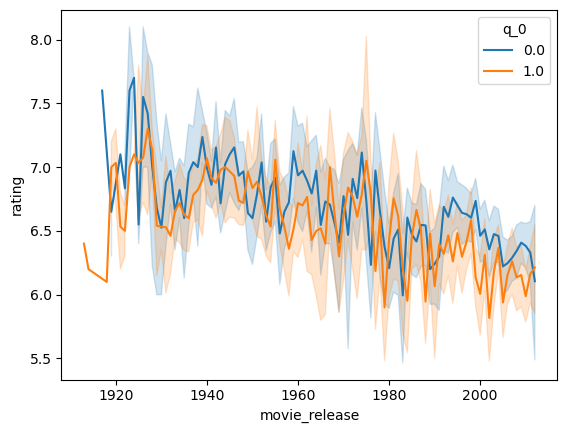

In [24]:
sns.lineplot(data = df, x= 'movie_release', y='rating', hue = 'q_0', palette = sns.color_palette()[:df.q_0.nunique()])

# C) Analysis of ratings

In [25]:
display(df)

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers,ratings_with_weight
4518,31046582,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,97.0,{},{'/m/09c7w0': 'United States of America'},1999.0,"['Comedy', 'Adventure', 'Romance', 'Thriller',...",tt0176948,4.9,501.0,10000000000000000000,4.900000e+00+5.010000e+ 02j
5236,4600711,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,109.0,"{'/m/03115z': 'Mandarin Chinese', '/m/0653m': ...","{'/m/03h64': 'Hong Kong', '/m/0d05w3': 'China'}",2003.0,"['Crime', 'Adventure', 'Romance', 'Thriller', ...",tt0413515,6.2,501.0,10011001000001110000,6.200000e+00+5.010000e+ 02j
4089,25751926,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1935.0,"['Music', 'Comedy', 'Romance']",tt0027188,6.3,503.0,00000111111000001000,6.300000e+00+5.030000e+ 02j
3545,18083698,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,87.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1964.0,"['Comedy', 'Romance']",tt0161612,4.9,504.0,10100001000000000000,4.900000e+00+5.040000e+ 02j
5124,16797102,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1934.0,"['Comedy', 'Romance', 'Black-and-white', 'Crime']",tt0025290,6.3,504.0,00100000000000100000,6.300000e+00+5.040000e+ 02j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,8980330,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},2008.0,"['Comedy', 'Adventure', 'Romance', 'Family', '...",tt0910970,8.4,1170697.0,00000010000110100000,8.400000e+00+1.170697e+ 06j
1220,321496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,143.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},2003.0,"['Adventure', 'Comedy', 'Romance', 'Action', '...",tt0325980,8.1,1180834.0,00000101001001001010,8.100000e+00+1.180834e+ 06j
3744,44122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,100.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1999.0,"['Comedy', 'Romance', 'Satire', 'Black Comedy'...",tt0169547,8.3,1190830.0,00000001000000000000,8.300000e+00+1.190830e+ 06j
1469,52371,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,194.0,"{'/m/02bjrlw': 'Italian Language', '/m/02h40lc...",{'/m/09c7w0': 'United States of America'},1997.0,"['Adventure', 'Romance', 'History', 'Fiction',...",tt0120338,7.9,1252013.0,01111111011000001001,7.900000e+00+1.252013e+ 06j


In [26]:
df_cleaned = df.dropna(subset=questions_list)

#define predictor and response variables
X, y = df_cleaned[questions_list], df_cleaned.rating

#fit regression model
reg = LinearRegression().fit(X, y)

#print(reg.coef_)
print(f"For this regression, r-squared score is : {reg.score(X, y)}")

For this regression, r-squared score is : 0.027394034513873233


The model may be too simple... We should maybe try to take into account interaction terms ! 

In [27]:
X, y = df_cleaned[questions_list].to_numpy(), df_cleaned.rating.to_numpy()

print(f"Initially: \nX has shape {X.shape}\ny has shape {y.shape}\n")

degree = 2
poly = PolynomialFeatures(interaction_only=True,include_bias = False, degree = degree)
X_interactions = poly.fit_transform(X)
print(f"After adding interactions terms up to degree {degree}: \nX has shape : {X_interactions.shape}\n")

reg = LinearRegression()
reg.fit(X_interactions,y)
print(f"The r-squared score is {reg.score(X_interactions, y)}")

cv_scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation mean-squared error : {-cv_scores}')

Initially: 
X has shape (4150, 20)
y has shape (4150,)

After adding interactions terms up to degree 2: 
X has shape : (4150, 210)

The r-squared score is 0.07397542930539525
Cross-Validation mean-squared error : [0.88914016 0.71852446 0.75480199 0.87936987 0.88448584]


This is bad. Whether it's degree 2,3 or 4, we either overfit or underfit... At this point we can wonder whether it's infact a problem of our model, or of the data. Let us try one last model : the random forest.

# D) Random Forest

In [28]:
cleaned_questions_list = ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_16', 'q_17', 'q_18', 'q_19']

In [29]:
df_cleaned = df.dropna(subset=cleaned_questions_list)
X, y = df_cleaned[cleaned_questions_list], df_cleaned.rating

# Create an instance of a random forest regressor, using sklearn.
regressor = RandomForestRegressor(n_estimators=5, random_state=42, max_depth = 15)

# Fit the regressor with X and y data.
regressor.fit(X, y)

# Make predictions for the initial data.
predictions = regressor.predict(X)
 
# Extract MSE and R2 scores to evaluate the model.
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.3544583669870925
R-squared: 0.5627141195225693


This seems okay, let us perform cross-validation to verify that we indeed predict accurately !

In [30]:
# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv = 5, scoring = 'neg_mean_squared_error')  # Adjust the number of folds as needed

print(f'Cross-Validation scores: {cv_scores}')

Cross-Validation scores: [-1.17429774 -0.98350543 -1.10886058 -1.23261189 -1.16112942]


We obtain a MSE of around 1 in each case, but the R2 was high. This means we are (again) overfitting...

In [31]:
feature_importances = regressor.feature_importances_
print('Feature Importances:', feature_importances)

Feature Importances: [0.01312449 0.05661798 0.0720057  0.03818262 0.05755942 0.06256498
 0.06537755 0.06153837 0.05569483 0.07479415 0.06797663 0.04687164
 0.04167406 0.06776818 0.06183623 0.05501351 0.05376224 0.04763742]


Whether it is a random forest, a naive regression or a regression with interaction terms, we always do bad in the prediction. 

We could thus say there is no clear and simple model as to how movies are rated. In a sense, this is reassuring : humans are not robots, and we do not appreciate movies based solely on a yes-no flow chart concerning the plot ! There is much more to movies than just the plots :)

Also, keep in mind that although checked to be rather correct, GPT (and any question-answering model nowadays) results may be inaccurate, especially when a question expresses "feelings", or requires interpretation (e.g. "Is the ending sad").

In the end, does this mean we can not do anything using this data ? Not at all ! In fact, although there is no clear way to predict a movie's success based on its tropes, we can still analyze which tropes are positively and negatively correlated (think about the barplots above). We can even do statistical tests based on matchings, on a subset of relevant questions.

# E) Feature Selection

As seen above, many questions seem to be irrelevant. We thus focus on 6 or 7 questions, in order to perform matchings and statistical tests. That way, we ensure that we have enough movies to make a matching.

In [32]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import  LinearRegression

model =  LinearRegression()  # Choose an appropriate model
rfe = RFECV(model, step=1, cv=5, scoring='neg_mean_squared_error')
fit = rfe.fit(X, y)

selected_features = list(zip(X.columns[fit.support_], fit.estimator_.coef_)) 
score = fit.score(X, y)

selected_features.sort(key = lambda x: np.abs(x[1]))
print("Selected features/Feature importance :")
for feature in selected_features : 
    print(f"   {feature[0]} : {round(feature[1], 2)}")
    
print(f"Score : {round(score, 2)}\n")

Selected features/Feature importance :
   q_11 : 0.04
   q_6 : 0.07
   q_2 : -0.08
   q_1 : -0.08
   q_19 : 0.09
   q_18 : 0.1
   q_4 : 0.11
   q_3 : 0.12
   q_0 : -0.22
Score : 0.03



Note that again, the score is really low. This is normal, as, as previously seen, there is no way to predict accurately ratings of the movies.

There are 9 significant features, which yields 512 bins. This is a bit too much for 4000 movies, so we choose the 7 most important questions, ie only 128 bins.

In [33]:
selected_questions = ['q_0', 'q_3', 'q_4', 'q_18']

# Questions to remove, computes 'questions_list - selected_questions'
questions_to_remove = [x for x in questions_list if x not in selected_questions]

print(questions_to_remove)

filtered_df = df_cleaned.drop(columns = questions_to_remove)

filtered_df.head(3)

['q_1', 'q_2', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_19']


,movie_id,q_0,q_3,q_4,q_18,total,index,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers,ratings_with_weight
4518,31046582,1.0,0.0,0.0,0.0,1.0,70434,Love and Action in Chicago,NaN,97.0,{},{'/m/09c7w0': 'United States of America'},1999.0,"['Comedy', 'Adventure', 'Romance', 'Thriller',...",tt0176948,4.9,501.0,10000000000000000000,4.9+501.0j
5236,4600711,1.0,1.0,1.0,0.0,7.0,81815,Goddess of Mercy,NaN,109.0,"{'/m/03115z': 'Mandarin Chinese', '/m/0653m': ...","{'/m/03h64': 'Hong Kong', '/m/0d05w3': 'China'}",2003.0,"['Crime', 'Adventure', 'Romance', 'Thriller', ...",tt0413515,6.2,501.0,10011001000001110000,6.2+501.0j
4089,25751926,0.0,0.0,0.0,0.0,7.0,63883,We're in the Money,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1935.0,"['Music', 'Comedy', 'Romance']",tt0027188,6.3,503.0,00000111111000001000,6.3+503.0j


# F) Observational Study : GPT questions

We were unable to predict ratings of movies based on their ratings, and also unable to perform a clean regression. But this does not mean we are done ! We can still analyze whether clichés are positively or negatively correlated ! 

In [34]:
def top_n_indices(data, n):
    ind = np.argpartition(data, -n)[-n:]
    ind = ind[np.argsort(data[ind])][::-1]
    return ind

### 1) Question 0 : do people hate weddings stopped at the altar ? :(

First, we notice that in fact, the number of votes is significantly different between the movies with a wedding stopped at the altar or not.

In [35]:
romances_df = df.copy()

<Axes: xlabel='q_0', ylabel='nb_votes'>

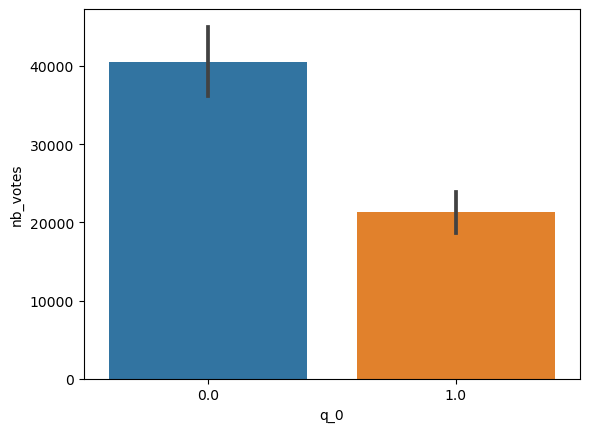

In [36]:
sns.barplot(romances_df[['q_0', 'rating', 'nb_votes']], x='q_0', y ='nb_votes')

We thus have to reduce this bias ! We will create the matching based on the 4 most significant questions, as well as on the number of votes

In [132]:
def create_matching_gpt(question, df):    
    
    # If the question to test is one of the selected questions.
    question_is_selected_feature = (question in [0, 3, 4, 18])
    
    selected_questions = ['q_0', 'q_3', 'q_4', 'q_18']
    
    # If not, we need to add the tested question to the questions we keep.
    if(not question_is_selected_feature) :
        q_tested = 'q_' + str(question)
        selected_questions.append(q_tested)
        
    questions_to_remove = [x for x in questions_list if x not in selected_questions]
    filtered_df = df.drop(columns = questions_to_remove).copy()
    
    if(question == 0) : 
        q_0, q_3, q_4, q_18 = 1, 0, 0, 0
    elif(question == 3) : 
        q_0, q_3, q_4, q_18 = 0, 1, 0, 0
    elif(question == 4) : 
        q_0, q_3, q_4, q_18 = 0, 0, 1, 0
    elif(question == 18) : 
        q_0, q_3, q_4, q_18 = 0, 0, 0, 1
    else : 
        q_0, q_3, q_4, q_18 = 0, 0, 0, 0
        
            
    # First, we extract the indices of all the movies with binary answers.
    # Control group consists of only 0s movies
    # Treatment group has only 0s, except for a 1 at the position of the tested question
    if(question_is_selected_feature) : 
        control_indices = filtered_df[(filtered_df['q_0'] == 0) & (filtered_df['q_3'] == 0) & (filtered_df['q_4'] == 0) & (filtered_df['q_18'] == 0)].index
        treatment_indices = filtered_df[(filtered_df['q_0'] == q_0) & (filtered_df['q_3'] == q_3) & (filtered_df['q_4'] == q_4) & (filtered_df['q_18'] == q_18)].index
        total = list(control_indices) + list(treatment_indices)
    else : 
        control_indices = filtered_df[(filtered_df[q_tested] == 0) & (filtered_df['q_0'] == 0) & (filtered_df['q_3'] == 0) & (filtered_df['q_4'] == 0) & (filtered_df['q_18'] == 0)].index
        treatment_indices = filtered_df[(filtered_df[q_tested] == 1) &  (filtered_df['q_0'] == q_0) & (filtered_df['q_3'] == q_3) & (filtered_df['q_4'] == q_4) & (filtered_df['q_18'] == q_18)].index
        total = list(control_indices) + list(treatment_indices)

    # We now extract the sub-dataframes from the indices.
    control = filtered_df.loc[control_indices]
    control = control.sort_values(by = 'nb_votes')

    treatment = filtered_df.loc[treatment_indices]
    treatment = treatment.sort_values(by = 'nb_votes')
    
    # This creates the columns names, useful for later.
    cols_x = list(treatment.columns + '_x')
    cols_x.remove('nb_votes_x')
    cols_y = list(treatment.columns + '_y')
    cols_y.remove('nb_votes_y')

    # Perform a merge : for each movie in the treatment group, this pairs it
    # with the movie in the control group with the closest number of votes    
    test = pd.merge_asof(treatment, control, on="nb_votes", direction="nearest")

    # After the pairing, extract the groups into two separate datasets
    treatment_matched = test[cols_x].copy()
    treatment_matched.rename(mapper = lambda name : name[:-2], axis='columns', inplace=True)
    treatment_matched = treatment_matched.merge(filtered_df[['movie_id','nb_votes']],on='movie_id', how='left')

    control_matched = test[cols_y].copy()
    control_matched.rename(mapper = lambda name : name[:-2], axis='columns', inplace=True)
    control_matched = control_matched.merge(filtered_df[['movie_id','nb_votes']],on='movie_id', how='left')
    

    matching = pd.concat((control_matched, treatment_matched))
    
    return matching, control_matched, treatment_matched
    

In [133]:
#features_dict = {'q_0' : '1000', 'q_3' :'0100', 'q_4' :'0010', 'q_18' : '0001'}

def get_standardized_mean_diff(treatment, control):
    return np.abs(treatment.mean()-control.mean())/np.sqrt(treatment.std()**2+control.std()**2)


def observational_regression_gpt(question) :
    
    matching, control_matched, treatment_matched = create_matching_gpt(question, df)
    votes_smd = get_standardized_mean_diff(control_matched['nb_votes'], treatment_matched['nb_votes'])
    release_smd = get_standardized_mean_diff(control_matched['movie_release'], treatment_matched['movie_release'])
    mod = smf.ols(formula='rating ~ ' + 'q_' + str(question), data=matching)
    
    return round(votes_smd, 4), round(release_smd, 4), mod.fit(), len(control_matched)
    

In [144]:
for i in range(20): 
    question = 'q_' + str(i)
    votes_smd, release_smd, fit, size = observational_regression_gpt(i)
    pval, coeff = fit.pvalues.loc[question], fit.params.iloc[1]   
    if(pval < 0.15) : 
        print(f"question {i} : ")
        print(f"For a matching of {size} pairs, the statistics are : \n\t- SMD for votes = {votes_smd}\n\t- SMD for release year = {release_smd}\n\t- coefficient = {round(coeff, 4)}\n\t- p_value = {round(pval, 4)}")
        print("--------------------------------------------------")
    

question 0 : 
For a matching of 577 pairs, the statistics are : 
	- SMD for votes = 0.0002
	- SMD for release year = 0.0534
	- coefficient = -0.1582
	- p_value = 0.0031
--------------------------------------------------
question 3 : 
For a matching of 280 pairs, the statistics are : 
	- SMD for votes = 0.0198
	- SMD for release year = 0.0468
	- coefficient = 0.2154
	- p_value = 0.0051
--------------------------------------------------
question 6 : 
For a matching of 309 pairs, the statistics are : 
	- SMD for votes = 0.0007
	- SMD for release year = 0.0611
	- coefficient = -0.123
	- p_value = 0.0889
--------------------------------------------------
question 10 : 
For a matching of 256 pairs, the statistics are : 
	- SMD for votes = 0.0023
	- SMD for release year = 0.1006
	- coefficient = -0.302
	- p_value = 0.0001
--------------------------------------------------
question 15 : 
For a matching of 116 pairs, the statistics are : 
	- SMD for votes = 0.0029
	- SMD for release year = 0.13

That's good ! 

For question 0 for example, we found 576 pairs of movies that have the same answers on the most important questions. Moreover, we made an approximate matching based on their number of votes. This is confirmed through the SMD criterion, which is extremely low (around .0002).

This way, we reduces all the possible biases. In the end, we can confirm : as the p-value is really low, we can thus accept the hypothesis that average rating for movies with a wedding stopped at the altar and without is the same!

---

### A story of fate :
#### Or the conclusion

From the matched study, we see that 3 questions have a statistically significant (at a 95%-level) impact on ratings ! 

- **Weddings stopped at the altar (q.0)**, have a **negative** influence (on average -0.14) on the ratings.
- **Impossible romances because of different social status (q.3)** have a **positive** influence (on average 0.22) on the ratings.
- **Love triangles (q.10)** have a **negative** influence (on average -0.30) on the ratings.

If we extend it to a 90%-level, we also notice that : 
- **Bad boy protagonists (q.16)** have a **negative** influence (on average -0.1) on the ratings.
- **Meet-cutes (q.6)** have a **negative** influence (on average -0.1) on the ratings.

It seems like love triangles and weddings stopped at the altar are annoying us. This could be interesting to see whether it changed accross the years. Perhaps we got bored of always seeing these two clichés ? Weddings stopped at the altar are indeed often mocked in movies (think about Shrek 1).

On the contrary, we seem to really enjoy impossible romances. Is it because of the fate ? Do we take pride in seeing lovers torn apart by this cruel world ? 

# G) Observational study : Personas

In [145]:
personas_list = [f'p_{i}' for i in range(20)]

In [146]:
personas_df = pd.read_csv('./Data/Preprocessed/tiens_robinson.tsv', delimiter='\t')

personas_df = personas_df.merge(df[['movie_id', 'nb_votes', 'movie_release']], on='movie_id', how='left')

one_hot = personas_df.copy()
one_hot[personas_list] = one_hot[personas_list].apply(lambda x : x > 0).astype(int)
one_hot['movie_release'] = one_hot['movie_release'].astype(np.int64)
one_hot['nb_votes'] = one_hot['nb_votes'].astype(int)
display(one_hot)

,movie_id,rating,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,...,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,nb_votes,movie_release
0,4227,8.1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,178196,1975
1,5313,7.9,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,278270,2000
2,9979,7.5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,363939,1999
3,11223,7.1,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,0,0,161640,1994
4,19715,6.3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,224332,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2788,34222453,6.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,739,2010
2789,34645036,6.3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,43769,2012
2790,35193550,6.8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7812,2011
2791,35587809,7.2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,104432,2012


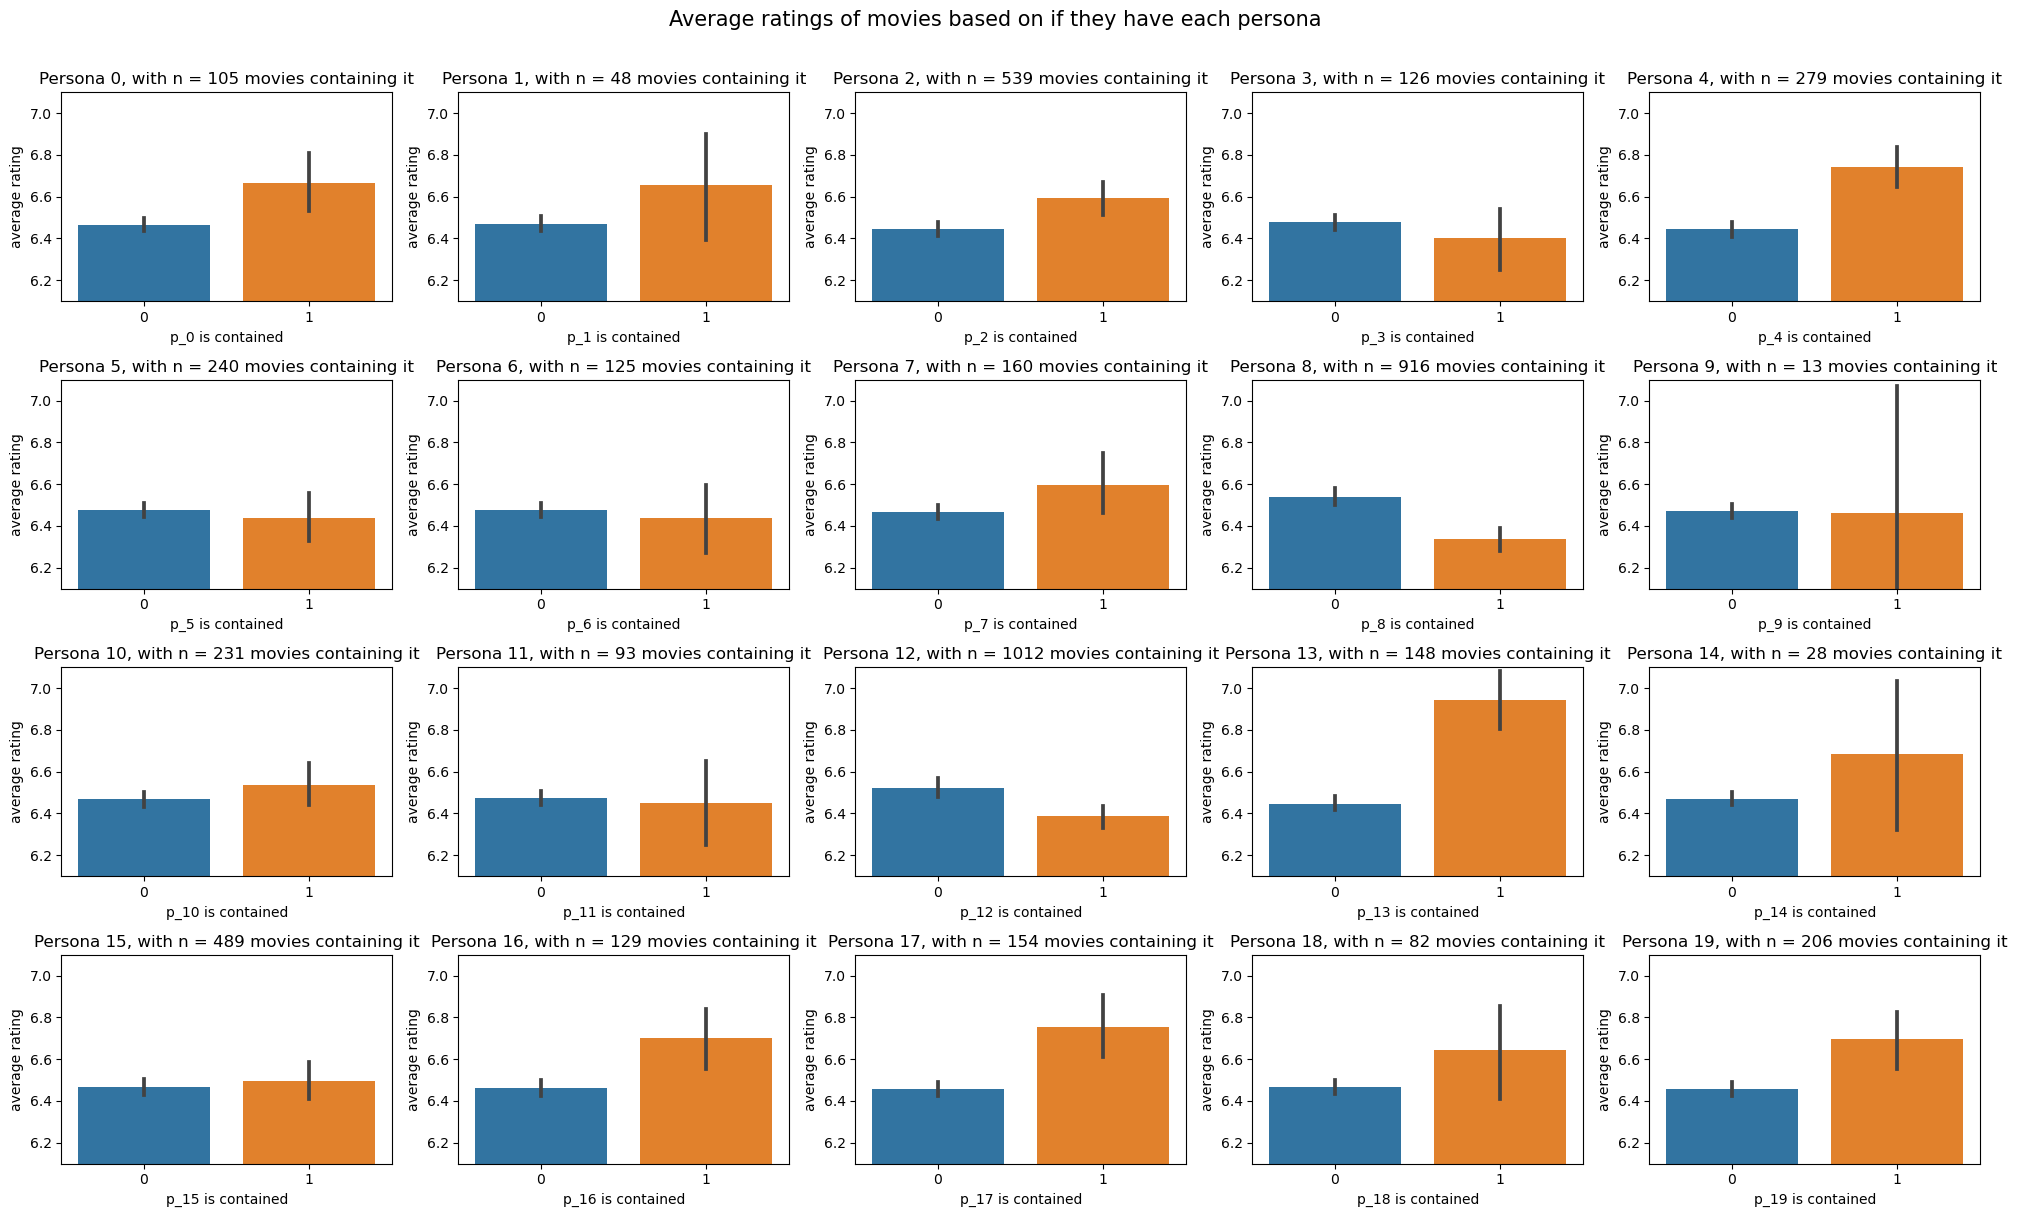

In [147]:
def plot_error_bars(df, nr_rows, nr_cols):
    
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
    
    for r in range(nr_rows):
        for c in range(nr_cols):
            
            i = 5*r+c
            persona = 'p_' + str(i)
            
            count = len(df[df[persona] == 1])
            sns.barplot(data=df, x=persona, y='rating', ax=ax[r][c])
            ax[r][c].set_ylim(6.1, 7.1)
                
            ax[r][c].set_xlabel(f"p_{i} is contained")
            ax[r][c].set_ylabel('average rating')
            ax[r][c].set_title(f"Persona {i}, with n = {count} movies containing it")
    
    fig.suptitle('Average ratings of movies based on if they have each persona', y=1.01, fontsize=15)
    plt.tight_layout()    
    plt.show()
   
plot_error_bars(one_hot, 4, 5)

Personas 2, 4, 8, 12, 19 are the 5 personas that have a statistically significant impact on ratings with the highest number of movies. We thus choose them as "representants" for the matching.

In [148]:
selected_personas = ['p_2', 'p_4', 'p_8', 'p_12', 'p_19']
matching = one_hot.groupby(selected_personas).size().reset_index().rename(columns={0:'count'})

def top_n_indices(data, n):
    ind = np.argpartition(data, -n)[-n:]
    ind = ind[np.argsort(data[ind])][::-1]
    return ind

print(matching.iloc[top_n_indices(matching['count'], 8)])

    p_2  p_4  p_8  p_12  p_19  count
2     0    0    0     1     0    589
4     0    0    1     0     0    523
0     0    0    0     0     0    468
14    1    0    0     0     0    334
6     0    0    1     1     0    280
8     0    1    0     0     0    178
1     0    0    0     0     1    125
16    1    0    0     1     0     55


In [149]:
def create_matching_personas(persona, df):    
    
    # If the question to test is one of the selected questions.
    persona_is_selected_feature = (persona in [2, 4, 8, 12, 19])
    
    selected_personas = ['p_2', 'p_4', 'p_8', 'p_12', 'p_19']
   
    # If not, we need to add the tested question to the questions we keep.
    if(not persona_is_selected_feature) :
        p_tested = 'p_' + str(persona)
        selected_personas.append(p_tested)
        
    personas_to_remove = [x for x in personas_list if x not in selected_personas]
    filtered_df = df.drop(columns = personas_to_remove).copy()
    
    if(persona == 2): 
        p_2, p_4, p_8, p_12, p_19 = 1, 0, 0, 0, 0
    elif(persona == 4): 
        p_2, p_4, p_8, p_12, p_19 = 0, 1, 0, 0, 0
    elif(persona == 8): 
        p_2, p_4, p_8, p_12, p_19 = 0, 0, 1, 0, 0
    elif(persona == 12): 
        p_2, p_4, p_8, p_12, p_19 = 0, 0, 0, 1, 0
    elif(persona == 19):
        p_2, p_4, p_8, p_12, p_19 = 0, 0, 0, 0, 1
    else : 
        p_2, p_4, p_8, p_12, p_19 = 0, 0, 0, 0, 0
        
            
    # First, we extract the indices of all the movies with binary answers.
    # Control group consists of only 0s movies
    # Treatment group has only 0s, except for a 1 at the position of the tested question
    if(persona_is_selected_feature) : 
        control_indices = filtered_df[(filtered_df['p_2'] == 0) & (filtered_df['p_4'] == 0) & (filtered_df['p_8'] == 0) & (filtered_df['p_12'] == 0) & (filtered_df['p_19'] == 0)].index
        treatment_indices = filtered_df[(filtered_df['p_2'] == p_2) & (filtered_df['p_4'] == p_4) & (filtered_df['p_8'] == p_8) & (filtered_df['p_12'] == p_12) & (filtered_df['p_19'] == p_19)].index
        total = list(control_indices) + list(treatment_indices)
    else : 
        control_indices = filtered_df[(filtered_df[p_tested] == 1) & (filtered_df['p_2'] == 0) & (filtered_df['p_4'] == 0) & (filtered_df['p_8'] == 0) & (filtered_df['p_12'] == 0) & (filtered_df['p_19'] == 0)].index
        treatment_indices = filtered_df[(filtered_df[p_tested] == 1) &  (filtered_df['p_2'] == 0) & (filtered_df['p_4'] == 0) & (filtered_df['p_8'] == 0) & (filtered_df['p_12'] == 0) & (filtered_df['p_19'] == 0)].index
        total = list(control_indices) + list(treatment_indices)

    # We now extract the sub-dataframes from the indices.
    control = filtered_df.loc[control_indices]
    control = control.sort_values(by = 'nb_votes')

    treatment = filtered_df.loc[treatment_indices]
    treatment = treatment.sort_values(by = 'nb_votes')
    
    # This creates the columns names, useful for later.
    cols_x = list(treatment.columns + '_x')
    cols_x.remove('nb_votes_x')
    cols_y = list(treatment.columns + '_y')
    cols_y.remove('nb_votes_y')

    # Perform a merge : for each movie in the treatment group, this pairs it
    # with the movie in the control group with the closest number of votes  
    test = pd.merge_asof(treatment, control, on="nb_votes", direction="nearest")

    # After the pairing, extract the groups into two separate datasets
    treatment_matched = test[cols_x].copy()
    treatment_matched.rename(mapper = lambda name : name[:-2], axis='columns', inplace=True)
    treatment_matched = treatment_matched.merge(filtered_df[['movie_id','nb_votes']],on='movie_id', how='left')

    control_matched = test[cols_y].copy()
    control_matched.rename(mapper = lambda name : name[:-2], axis='columns', inplace=True)
    control_matched = control_matched.merge(filtered_df[['movie_id','nb_votes']],on='movie_id', how='left')
    

    matching = pd.concat((control_matched, treatment_matched))
    
    return matching, control_matched, treatment_matched
    

In [150]:
def get_standardized_mean_diff(treatment, control):
    return np.abs(treatment.mean()-control.mean())/np.sqrt(treatment.std()**2+control.std()**2)


def observational_regression_personas(persona) :
    
    matching, control_matched, treatment_matched = create_matching_personas(persona, one_hot)
    votes_smd = get_standardized_mean_diff(control_matched['nb_votes'], treatment_matched['nb_votes'])
    release_smd = get_standardized_mean_diff(control_matched['movie_release'], treatment_matched['movie_release'])
    mod = smf.ols(formula='rating ~ ' + 'p_' + str(persona), data=matching)
    return round(votes_smd, 4), round(release_smd, 4), mod.fit(), len(control_matched)

In [153]:
for i in range(20): 
    
    persona = 'p_' + str(i)
    votes_smd, release_smd, fit, size = observational_regression_personas(i)
    pval, coeff = fit.pvalues.loc[persona], fit.params.iloc[1] 
    
    if((size > 100) & (pval < 0.1) ) : 
        print(f"Persona {i} : ")
        print(f"For a matching of {size} pairs, the statistics are : \n\t- SMD for votes = {votes_smd}\n\t- SMD for release year = {release_smd}\n\t- coefficient = {round(coeff, 4)}\n\t- p_value = {round(pval, 4)}")
        print("--------------------------------------------------")
    

Persona 2 : 
For a matching of 334 pairs, the statistics are : 
	- SMD for votes = 0.0025
	- SMD for release year = 0.0764
	- coefficient = -0.1275
	- p_value = 0.0741
--------------------------------------------------
Persona 4 : 
For a matching of 178 pairs, the statistics are : 
	- SMD for votes = 0.0003
	- SMD for release year = 0.3385
	- coefficient = 0.3657
	- p_value = 0.0001
--------------------------------------------------
Persona 8 : 
For a matching of 523 pairs, the statistics are : 
	- SMD for votes = 0.0003
	- SMD for release year = 0.1515
	- coefficient = -0.2813
	- p_value = 0.0
--------------------------------------------------
Persona 12 : 
For a matching of 589 pairs, the statistics are : 
	- SMD for votes = 0.002
	- SMD for release year = 0.1162
	- coefficient = -0.2944
	- p_value = 0.0
--------------------------------------------------
Persona 15 : 
For a matching of 149 pairs, the statistics are : 
	- SMD for votes = 0.0
	- SMD for release year = 0.0
	- coefficien

As we have more data concerning personas, we only consider matchings of size at least 100. That way, we ensure to have enough data to confirm our claims.

From the matched study, we see that 3 questions have a statistically significant (at a 95%-level) impact on ratings !
- **Persona 2** has a **negative** influence (on average +0.13) on the rating.
- **Persona 4** has a **positive** influence (on average +0.37) on the rating.
- **Persona 8** has a **negative** influence (on average -0.29) on the rating.
- **Persona 12** has a **negative** influence (on average -0.3) on the rating.
- **Persona 15** has a **positive** influence (on average +3.2) on the rating.


However, Persona 4 has a SMD for the release year of around 0.35. This is way above the 0.1 threshold that we usually use. Also note how Persona 8 has a 0.15 release year SMD. This is quite close to the 0.1 threshold, but still above it : we should be careful when interpreting these results ! 

### Quick analysis of release year bias for Personas 4 and 8

In [176]:
for i in [4,8] : 
    
    print(f"Persona {i}:")
    matching, control_matched, treatment_matched = create_matching_personas(i, one_hot)
    votes_smd = get_standardized_mean_diff(control_matched['nb_votes'], treatment_matched['nb_votes'])
    release_smd = get_standardized_mean_diff(control_matched['movie_release'], treatment_matched['movie_release'])
    fit = smf.ols(formula='rating ~ p_' + str(i), data=matching).fit()
    pval, coeff = fit.pvalues.loc['p_' + str(i)], fit.params.iloc[1] 
    
    control_mean = control_matched['movie_release'].mean()
    treatment_mean = treatment_matched['movie_release'].mean()

    print(f"  - Coefficient = {round(coeff,3)}\n  - Control mean = {round(control_mean)}\n  - Treatment mean = {round(treatment_mean)}\n")
    
# round(votes_smd, 4), round(release_smd, 4), mod.fit(), len(control_matched)

Persona 4:
  - Coefficient = 0.366
  - Control mean = 1985
  - Treatment mean = 1973

Persona 8:
  - Coefficient = -0.281
  - Control mean = 1984
  - Treatment mean = 1989



We see that there is a 12 years difference (on average) between movies with Persona 4 in it and without. This can explain quite well the difference of rating. Indeed, as the IMDB ratings were given in recent times (> 1990), there is a strong bias : the old movies that we watch nowadays are mostly "classics". No one (well, almost) watches bad old movies on purpose! 

However, Persona 8's results are a bit better. The mean difference is only of 5 years, coupled with a 0.15 SMD. One could argue that this difference might not be that significant : maybe Persona 8 is in fact a 'bad' persona for romance movies ?

Finally, one could also say that we should have done the matching exactly on release year first and then with the closest number of votes. This was done, and actually yields worse results. When matching first on the year, it is almost impossible to obtain low SMD for the number of votes ! Also, we noticed earlier that in fact number of votes is more correlated with results than the release year, so it makes sense to put the emphasis on it !